# Forward simulation 

In this notebook we demonstrate running a forward simulation with SimPEG to reproduce the E3D results. 

There are two important conventions that differ between these codes: 
- **coordinate system**: SimPEG uses a right-handed coordinate system with z-positive up, while E3D uses a left-handed coordinate system with z-positive down. Therefore, we need to multiply the currents that we read in by -1
- **fourier convention**: SimPEG uses the $+i\omega t$ convention, whereas E3D uses the $-i\omega t$ convention, so we multiply the imaginary component by -1 to compare outputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, SymLogNorm
from scipy.spatial import cKDTree
from string import ascii_lowercase

import discretize 

from simpeg import (
    maps,
    utils,
    data_misfit, 
    regularization, 
) 

import spcsem
from simpeg.electromagnetics import frequency_domain as fdem

set the default solver. Should ideally be Pardiso (obtained by installing `pydiso`) or Mumps (obtained by installing `pymumps`)

In [2]:
Solver = utils.solver_utils.get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

## read in E3D files 
- mesh
- conductivity model
- current density
- simulated data

In [3]:
mesh = discretize.TreeMesh.read_UBC("../e3d/J/octree_mesh_casing.txt")
conductivity_model = discretize.TreeMesh.read_model_UBC(mesh, "../e3d/J/model_casing.con")

In [4]:
jx_e3d = np.loadtxt("../e3d/J/J_X.txt")
jy_e3d = np.loadtxt("../e3d/J/J_Y.txt")
jz_e3d = np.loadtxt("../e3d/J/J_Z.txt")

In [5]:
jx = spcsem.utils.match_values_nearest(jx_e3d, mesh.edges_x)
jy = spcsem.utils.match_values_nearest(jy_e3d, mesh.edges_y)
jz = spcsem.utils.match_values_nearest(jz_e3d, mesh.edges_z)

plot cross sections of the current density

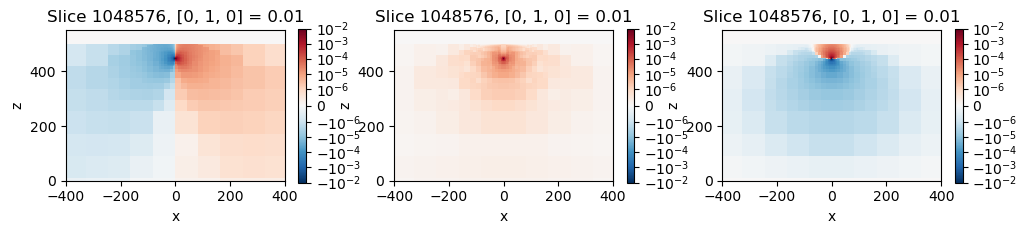

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))

for a, j, comp in zip(ax, [jx, jy, jz], ["x", "y", "z"]): 
    cb = plt.colorbar(mesh.plot_slice(
        getattr(mesh, f"average_edge_{comp}_to_cell") * j, 
        ax=a,
        normal="y", 
        pcolor_opts={"norm":SymLogNorm(vmin=-1e-2, vmax=1e-2, linthresh=1e-6), "cmap":"RdBu_r"},
    )[0], ax=a)
    a.set_xlim(np.r_[-1, 1]*400)
    a.set_ylim(np.r_[0, 550])
    a.set_aspect(1)

In [7]:
# load predicted data 
data_path = "../e3d/points"

In [8]:
data_locs = np.loadtxt(f"{data_path}/points.txt")
data_e3d = np.loadtxt(f"{data_path}/dpredFWD.txt")

In [9]:
data_e3d_x = data_e3d[::2, :]
data_e3d_y = data_e3d[1::2, :]

In [10]:
rx_x = np.unique(data_locs[:, 0])
rx_y = np.unique(data_locs[:, 1])

plot data from E3D

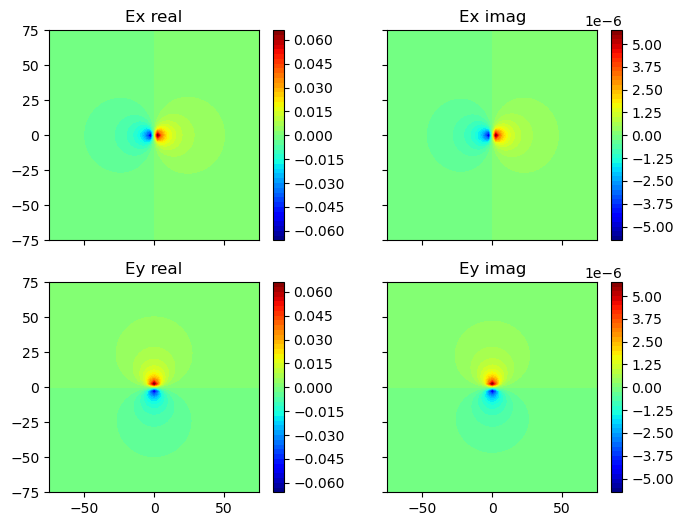

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for i, data_plot in enumerate([data_e3d_x, data_e3d_y]):
    for j, comp in enumerate(["real", "imag"]): 
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_y, data_plot[:, j].reshape(len(rx_x), len(rx_y), order="F"), levels=50,
                cmap="jet"
            ), ax=ax[i, j]
        )
        ax[i, j].set_title(f"E{ascii_lowercase[23+i]} {comp}")
for a in ax.flatten(): 
    a.set_aspect(1)

# setup and run SimPEG simulation 

parameters used for the E3D simulation

In [12]:
gravity_acceleration = 9.81 
density_water = 1000.0 
coupling_coefficient = 1e-5
frequency = 1 

In [13]:
# create receiver list
rx_list = [
    fdem.receivers.PointElectricField(locations=data_locs, orientation="x", component="real"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="x", component="imag"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="y", component="real"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="y", component="imag"),
]

### set up the Jsp Source

The class `spcsem.JspSource` is a custom source class that takes a pore pressure gradient, frequency, density of water and gravity acceleration. The coupling coefficient will be provided by the simulation. This is so that later on, we can invert for the coupling coefficient. 

In [14]:
# source current density. We multiply by -1 because of the difference in coordinate systems 
jsrc = (
    -np.hstack([jx, jy, jz])
)

In [15]:
source = spcsem.JspSource(
    receiver_list=rx_list, 
    frequency=frequency,
    pore_pressure_gradient=1/(-coupling_coefficient / (density_water*gravity_acceleration)) * jsrc,
    density_water=density_water, 
    gravity_acceleration=gravity_acceleration,
)

In [16]:
survey = fdem.Survey([source])

In [17]:
active_cells = mesh.cell_centers[:, 2] < 500, # all cells below 500m are active
coupling_coefficient_map = (
    maps.InjectActiveCells(
        mesh=mesh,
        active_cells=active_cells,
        value_inactive=0, # set coupling coefficient to 0 in air 
    ) 
)

In [18]:
sim = spcsem.Simulation3DElectricFieldSelfPotential(
    mesh=mesh, 
    survey=survey, 
    solver=Solver,
    sigma=conductivity_model, 
    coupling_coefficientMap=coupling_coefficient_map, 
    storeJ=True
)

In [19]:
%%time

dpred = sim.make_synthetic_data(coupling_coefficient*np.ones(np.sum(active_cells)))

/home/lheagy/miniforge3/envs/sp-csem-inv/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


CPU times: user 15min 17s, sys: 28.5 s, total: 15min 46s
Wall time: 50.6 s


## plot results 

Text(0.5, 0.98, 'SimPEG result')

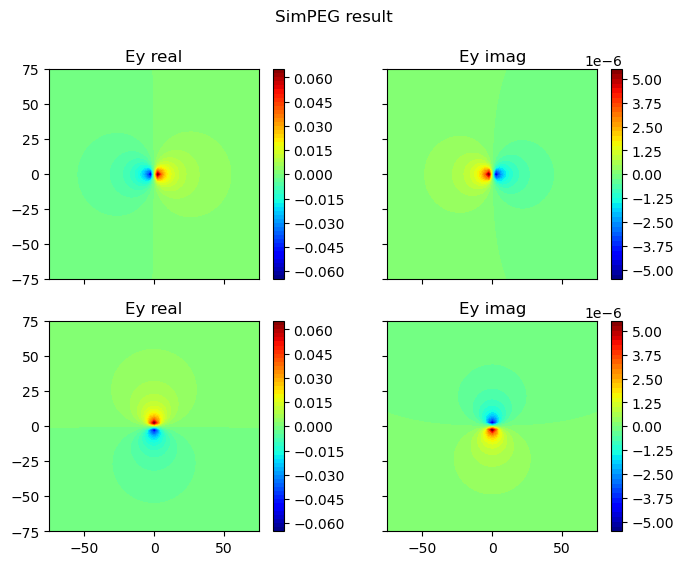

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for a, rx in zip(ax.flatten(), rx_list):
    plt.colorbar(
        a.contourf(
            rx_x, rx_y, dpred[source, rx].reshape(len(rx_x), len(rx_y), order="F"), levels=50,
            cmap="jet"
        ), ax=a
    )
    orientation = "x" if rx.component[0] == 1 else "y"
    a.set_title(f"E{orientation} {rx.component}")

    a.set_aspect(1)

fig.suptitle("SimPEG result")

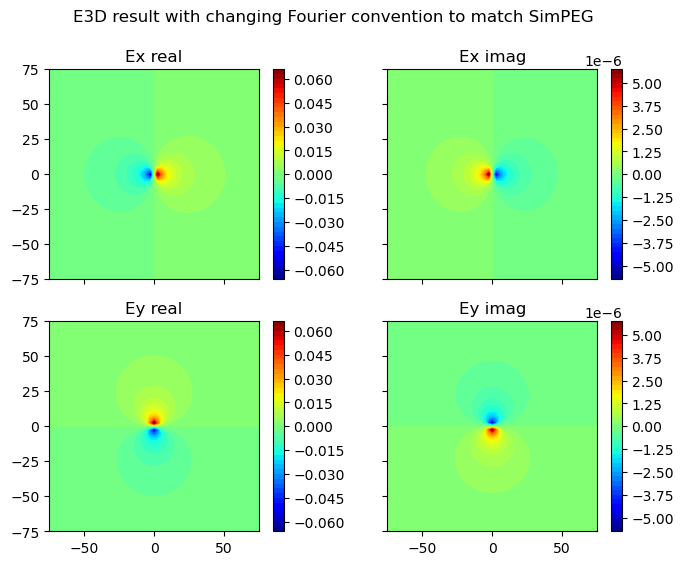

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for i, data_plot in enumerate([data_e3d_x, data_e3d_y]):
    for j, comp in enumerate(["real", "imag"]): 
        plot_e3d = data_plot[:, j].reshape(len(rx_x), len(rx_y), order="F")
        if comp == "imag":
            plot_e3d = -1 * plot_e3d # multiply imag component by -1 to match fourier convention
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_y, plot_e3d, levels=50,
                cmap="jet"
            ), ax=ax[i, j]
        )
        ax[i, j].set_title(f"E{ascii_lowercase[23+i]} {comp}")
for a in ax.flatten(): 
    a.set_aspect(1)

fig.suptitle("E3D result with changing Fourier convention to match SimPEG");

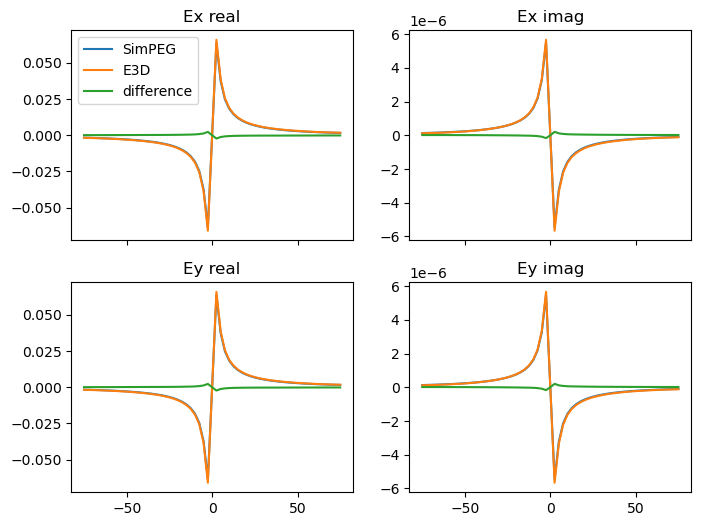

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

center_ind_y = int((len(rx_y)-1)/2)
center_ind_x = int((len(rx_x)-1)/2)
    
for a, rx in zip(ax.flatten(), rx_list):
    dplot = dpred[source, rx].reshape(len(rx_x), len(rx_y), order="F")
    # if subtract is not None: 
    #     dplot = dplot - subtract[source, rx].reshape(len(rx_x), len(rx_y), order="F")
    
    orientation = "x" if rx.orientation[0] == 1 else "y"

    if orientation == "x":
        if rx.component == "real":
            dplot_e3d = data_e3d_x[:, 0].reshape(len(rx_x), len(rx_y), order="F")
        elif rx.component == "imag":
            dplot_e3d = -1 * data_e3d_x[:, 1].reshape(len(rx_x), len(rx_y), order="F")
        a.plot(rx_x, dplot[center_ind_y, :], color="C0", label="SimPEG")
        a.plot(rx_x, dplot_e3d[center_ind_y, :], color="C1", label="E3D")
        a.plot(rx_x, dplot[center_ind_y, :] - dplot_e3d[center_ind_y, :], color="C2", label="difference")
    elif orientation == "y":
        if rx.component == "real":
            dplot_e3d = data_e3d_y[:, 0].reshape(len(rx_x), len(rx_y), order="F")
        elif rx.component == "imag":
            dplot_e3d = -1 * data_e3d_y[:, 1].reshape(len(rx_x), len(rx_y), order="F")
        a.plot(rx_y, dplot[:, center_ind_x], color="C0", label="SimPEG")
        a.plot(rx_y, dplot_e3d[:, center_ind_x], color="C1", label="E3D")
        a.plot(rx_y, dplot[:, center_ind_x] - dplot_e3d[:, center_ind_x], color="C2", label="difference")
    a.set_title(f"E{orientation} {rx.component}")
ax[0, 0].legend()


In [23]:
import simpeg
simpeg.Report()

--------------------------------------------------------------------------------
  Date: Fri Jul 04 15:50:22 2025 PDT

                OS : Linux (Ubuntu 20.04)
            CPU(s) : 48
           Machine : x86_64
      Architecture : 64bit
               RAM : 125.8 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23)
  [GCC 13.3.0]

            simpeg : 0.24.1.dev15+ge44476b14
        discretize : 0.11.3
       pymatsolver : 0.3.1
             numpy : 2.2.6
             scipy : 1.16.0
        matplotlib : 3.10.3
            geoana : 0.7.2
            libdlf : 0.3.0
            pydiso : 0.1.2
             numba : 0.61.2
              dask : 2025.5.1
           sklearn : 1.7.0
            pandas : 2.3.0
           IPython : 9.4.0
        ipywidgets : 8.1.7
               vtk : 9.4.2
            choclo : 0.3.2
--------------------------------------------------------------------------------